In [1]:
!pip install qiskit
!pip install qiskit-aer


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Niranjan P\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Niranjan P\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
# Deutsch Algorithm using Qiskit 2.x
# Compatible with Qiskit 2.0+ (2024–2025)

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# Choose the function type: 'constant_0', 'constant_1', 'balanced_0', 'balanced_1'
function_type = 'balanced_1'

def deutsch_oracle(qc, function_type):
    """Implements oracle Uf for given function type."""
    if function_type == 'constant_0':
        # f(x)=0 → Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x)=1 → Apply X on the output qubit
        qc.x(1)
    elif function_type == 'balanced_0':
        # f(x)=x → Apply CNOT (control: input, target: output)
        qc.cx(0, 1)
    elif function_type == 'balanced_1':
        # f(x)=NOT(x) → Apply X, then CNOT, then X
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

In [7]:
# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

In [5]:
# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

           ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ║ 
c: 1/════════════════════════════════════════╩═
                                             0 


In [6]:
# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


Measurement results: {'1': 1024}
→ Function is BALANCED.


In [8]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Helper function for simulation
def run_simulation(qc, shots=1024, simulator=None):
    if simulator is None:
        simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

print("--- 1. Custom Oracle Design: f(x) = x XOR 1 ---")

# n=1 (1 input qubit, 1 ancilla qubit)
n = 1
qc_custom = QuantumCircuit(n + 1, n)

# Initialize ancilla to |1>
qc_custom.x(n)
qc_custom.barrier()

# H-gates on all qubits
for qubit in range(n + 1):
    qc_custom.h(qubit)
qc_custom.barrier()

# Oracle for f(x) = x XOR 1
# This function is f(0)=1, f(1)=0.
# Oracle implementation: Controlled-X on ancilla,
# controlled by input |0>.
# This is equivalent to: X(q0), CX(q0, q1), X(q0)
qc_custom.x(0)
qc_custom.cx(0, 1)
qc_custom.x(0)
qc_custom.barrier()

# H-gates on input qubits
for i in range(n):
    qc_custom.h(i)
qc_custom.barrier()

# Measure input qubits
qc_custom.measure(range(n), range(n))

print("Circuit for f(x) = x XOR 1:")
print(qc_custom)

# Run simulation
counts_custom = run_simulation(qc_custom)
print("\nSimulation Results:")
print(counts_custom)

--- 1. Custom Oracle Design: f(x) = x XOR 1 ---
Circuit for f(x) = x XOR 1:
           ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘ ░ └╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────░──╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ░  ║ 
c: 1/═══════════════════════════════════════════╩═
                                                0 

Simulation Results:
{'1': 1024}



--- 2. Bloch Sphere Visualization ---

Bloch Sphere: After initial H-gates (State |+->)


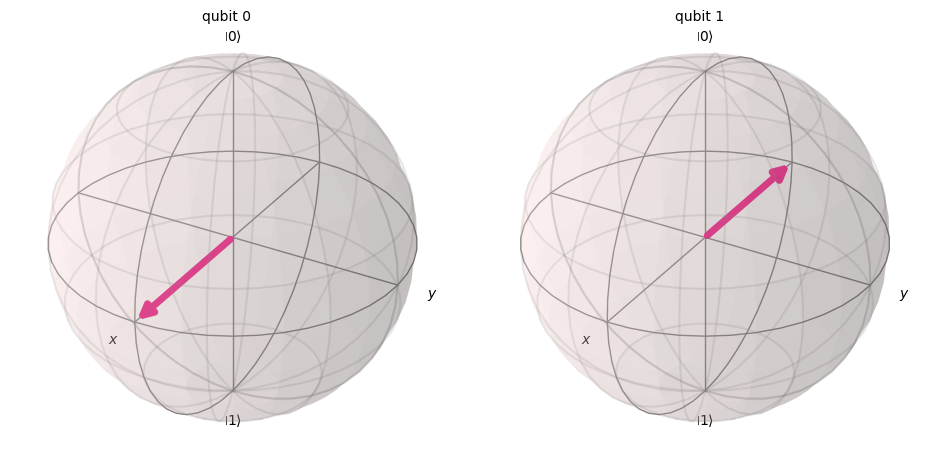


Bloch Sphere: After Oracle


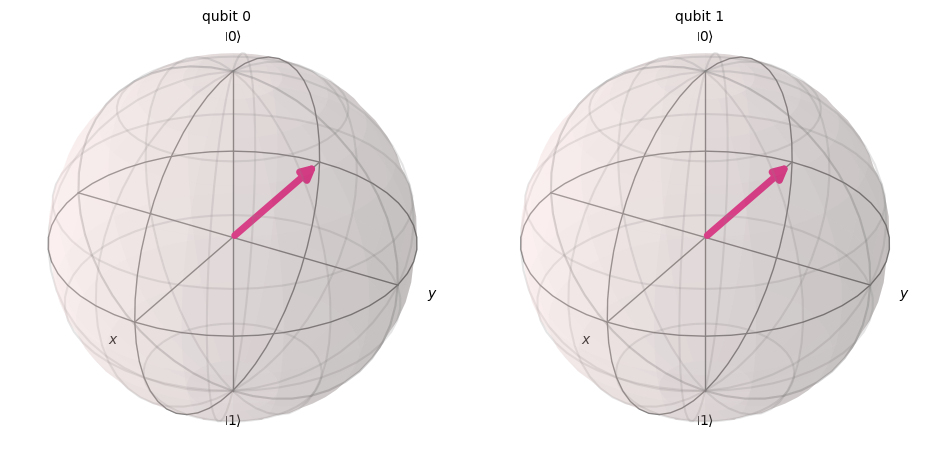

In [9]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit

print("\n--- 2. Bloch Sphere Visualization ---")

n = 1
qc_viz = QuantumCircuit(n + 1)
qc_viz.x(n) # Ancilla to |1>
qc_viz.barrier()

# State 1: After initial Hadamard gates
qc_viz.h(0)
qc_viz.h(1)
state1 = Statevector(qc_viz)
print("\nBloch Sphere: After initial H-gates (State |+->)")
display(plot_bloch_multivector(state1))

# State 2: After the oracle
qc_viz.barrier()
qc_viz.x(0)
qc_viz.cx(0, 1)
qc_viz.x(0)
state2 = Statevector(qc_viz)
print("\nBloch Sphere: After Oracle")
display(plot_bloch_multivector(state2))

In [10]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# This block assumes 'run_simulation' was defined in the first block
print("\n--- 3. Deutsch–Jozsa Extension (2-qubit input) ---")

n_2 = 2

# --- Case A: Balanced Function f(x1, x0) = x0 ---
print("\nCase A: 2-Qubit Balanced Function f(x1, x0) = x0")
qc_2_bal = QuantumCircuit(n_2 + 1, n_2)
qc_2_bal.x(n_2) # Ancilla to |1>
qc_2_bal.barrier()
qc_2_bal.h(range(n_2 + 1))
qc_2_bal.barrier()

# Oracle for f(x1, x0) = x0
# This is CNOT(x0, y)
qc_2_bal.cx(0, 2) # q0 is x0, q2 is ancilla y
qc_2_bal.barrier()

qc_2_bal.h(range(n_2))
qc_2_bal.barrier()
qc_2_bal.measure(range(n_2), range(n_2))

print("Circuit for 2-qubit balanced function:")
print(qc_2_bal)
counts_2_bal = run_simulation(qc_2_bal)
print("Simulation Results (Balanced):")
print(counts_2_bal)


# --- Case B: Constant Function f(x1, x0) = 1 ---
print("\nCase B: 2-Qubit Constant Function f(x1, x0) = 1")
qc_2_const = QuantumCircuit(n_2 + 1, n_2)
qc_2_const.x(n_2) # Ancilla to |1>
qc_2_const.barrier()
qc_2_const.h(range(n_2 + 1))
qc_2_const.barrier()

# Oracle for f(x1, x0) = 1
# This is X(y)
qc_2_const.x(2) # q2 is ancilla y
qc_2_const.barrier()

qc_2_const.h(range(n_2))
qc_2_const.barrier()
qc_2_const.measure(range(n_2), range(n_2))

print("Circuit for 2-qubit constant function:")
print(qc_2_const)
counts_2_const = run_simulation(qc_2_const)
print("Simulation Results (Constant):")
print(counts_2_const)


--- 3. Deutsch–Jozsa Extension (2-qubit input) ---

Case A: 2-Qubit Balanced Function f(x1, x0) = x0
Circuit for 2-qubit balanced function:
           ░ ┌───┐ ░       ░ ┌───┐ ░ ┌─┐   
q_0: ──────░─┤ H ├─░───■───░─┤ H ├─░─┤M├───
           ░ ├───┤ ░   │   ░ ├───┤ ░ └╥┘┌─┐
q_1: ──────░─┤ H ├─░───┼───░─┤ H ├─░──╫─┤M├
     ┌───┐ ░ ├───┤ ░ ┌─┴─┐ ░ └───┘ ░  ║ └╥┘
q_2: ┤ X ├─░─┤ H ├─░─┤ X ├─░───────░──╫──╫─
     └───┘ ░ └───┘ ░ └───┘ ░       ░  ║  ║ 
c: 2/═════════════════════════════════╩══╩═
                                      0  1 
Simulation Results (Balanced):
{'01': 1024}

Case B: 2-Qubit Constant Function f(x1, x0) = 1
Circuit for 2-qubit constant function:
           ░ ┌───┐ ░       ░ ┌───┐ ░ ┌─┐   
q_0: ──────░─┤ H ├─░───────░─┤ H ├─░─┤M├───
           ░ ├───┤ ░       ░ ├───┤ ░ └╥┘┌─┐
q_1: ──────░─┤ H ├─░───────░─┤ H ├─░──╫─┤M├
     ┌───┐ ░ ├───┤ ░ ┌───┐ ░ └───┘ ░  ║ └╥┘
q_2: ┤ X ├─░─┤ H ├─░─┤ X ├─░───────░──╫──╫─
     └───┘ ░ └───┘ ░ └───┘ ░       ░  ║  ║ 
c: 2/══════════════════


--- 4. Noise Impact ---
Running n=1 balanced circuit with 5% depolarizing noise...

Ideal results (n=1 balanced):
{'1': 1024}

Noisy results (n=1 balanced):
{'1': 880, '0': 144}


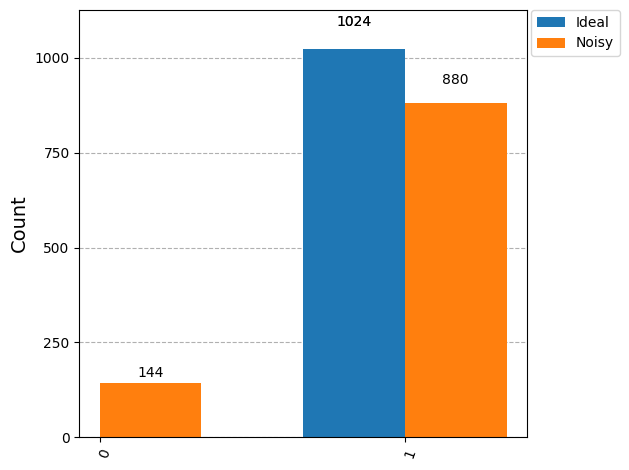

In [11]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# This block assumes 'qc_custom', 'counts_custom', and 'run_simulation'
# were defined and run in the first block.

print("\n--- 4. Noise Impact ---")

# Create a simple noise model
p_error = 0.05 # 5% depolarizing error
depol_error_1 = depolarizing_error(p_error, 1)
depol_error_2 = depolarizing_error(p_error, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_error_1, ['h', 'x'])
noise_model.add_all_qubit_quantum_error(depol_error_2, ['cx'])

# Create noisy simulator
noisy_sim = AerSimulator(noise_model=noise_model)

# Rerun the n=1 balanced circuit (qc_custom)
print("Running n=1 balanced circuit with 5% depolarizing noise...")
noisy_counts = run_simulation(qc_custom, simulator=noisy_sim)

print("\nIdeal results (n=1 balanced):")
print(counts_custom)
print("\nNoisy results (n=1 balanced):")
print(noisy_counts)
display(plot_histogram([counts_custom, noisy_counts], legend=['Ideal', 'Noisy']))

In [12]:
print("\n--- 5. Compare Classical vs Quantum Queries ---")

def classical_checker(func, n):
    """
    Classically determines if a function is constant or balanced.
    Returns ('type', num_queries)
    """
    num_inputs = 2**n
    max_queries = (2**(n - 1)) + 1

    # Get the output of the first input (all zeros)
    first_input = tuple([0] * n)
    first_output = func(first_input)

    queries = 1

    # Check up to max_queries
    for i in range(1, max_queries):
        # Generate the i-th input
        input_vec = tuple(int(x) for x in bin(i)[2:].zfill(n))

        output = func(input_vec)
        queries += 1

        if output != first_output:
            # We found a different output, must be balanced
            return ('Balanced', queries)

    # If we made it here, all max_queries inputs were the same
    return ('Constant', queries)

# Define our n=1 function: f(x) = x XOR 1
def f1(x_tuple): # x_tuple is (x0,)
    x0 = x_tuple[0]
    return x0 ^ 1

# Define our n=2 balanced function: f(x1, x0) = x0
def f2_bal(x_tuple): # x_tuple is (x1, x0)
    x0 = x_tuple[1]
    return x0

# Define our n=2 constant function: f(x1, x0) = 1
def f2_const(x_tuple): # x_tuple is (x1, x0)
    return 1

print("Quantum Query Complexity:")
print("The Deutsch-Jozsa algorithm requires exactly 1 quantum query, regardless of n.")

print("\nClassical (Deterministic) Query Complexity:")
n_classical_1 = 1
result_c1 = classical_checker(f1, n_classical_1)
print(f"n={n_classical_1} balanced function: {result_c1[0]}, Queries: {result_c1[1]} (Worst case: {(2**(n_classical_1 - 1)) + 1})")

n_classical_2 = 2
result_c2_bal = classical_checker(f2_bal, n_classical_2)
result_c2_const = classical_checker(f2_const, n_classical_2)
print(f"n={n_classical_2} balanced function: {result_c2_bal[0]}, Queries: {result_c2_bal[1]} (Worst case: {(2**(n_classical_2 - 1)) + 1})")
print(f"n={n_classical_2} constant function: {result_c2_const[0]}, Queries: {result_c2_const[1]} (Worst case: {(2**(n_classical_2 - 1)) + 1})")

print("\nComparison:")
print("Quantum: 1 query for all n.")
print(f"Classical (Worst Case): {2**(1 - 1) + 1} queries for n=1, and {2**(2 - 1) + 1} queries for n=2.")


--- 5. Compare Classical vs Quantum Queries ---
Quantum Query Complexity:
The Deutsch-Jozsa algorithm requires exactly 1 quantum query, regardless of n.

Classical (Deterministic) Query Complexity:
n=1 balanced function: Balanced, Queries: 2 (Worst case: 2)
n=2 balanced function: Balanced, Queries: 2 (Worst case: 3)
n=2 constant function: Constant, Queries: 3 (Worst case: 3)

Comparison:
Quantum: 1 query for all n.
Classical (Worst Case): 2 queries for n=1, and 3 queries for n=2.
